# Jan 2

In [1]:
import os, sys
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as ct
from astropy import units as u
# from spectral_cube import SpectralCube
import bisect
import time
from pathlib import Path


# constants & data import

In [2]:
# constants
g_A = 1.27 # [unitless] axial form factor
################
R_odot = 8.5 # [kpc] Sun's distance from centre of MW, from Clemens 1985
rho_s = 0.51 # [GeV/cm^3] DM radial scale for MW NFW profile; https://arxiv.org/abs/1906.08419
r_s = 8.1 # [kpc] DM radial scale for MW NFW profile; https://arxiv.org/abs/1906.08419; also used as distance scale for creating unitless quantities
################
# M_bulge = 1.5e10 * ct.M_sun.to_value(u.kg) # [kg]
# c_bulge = 0.6 # [kpc] bulge scale radius
# M_disk = 7e10 * ct.M_sun.to_value(u.kg) # [kg]
# b_disk = 4 # [kpc] disk scale radius
################
energyScale = 10 # [MeV] energy scale for creating unitless quantities

# importing C12 and O16 data: excitation energies [MeV] and GT strengths [unitless]
C12_data = 'C12_dEs_GTs.txt'
O16_data = 'O16_dEs_GTs.txt'
C12df = pd.read_csv(C12_data, sep='\t', names=['dE [MeV]', 'GT'], skiprows=1)
O16df = pd.read_csv(O16_data, sep='\t', names=['dE [MeV]', 'GT'], skiprows=1)

# nuclear info dictionary
nuc_dict = {'C12': {'mass [MeV]': 11274.78, 'mass [unitless]': 11274.78/energyScale, 'spin': 0.0, 'dEs [MeV]': C12df['dE [MeV]'], 'GTs': C12df['GT']}, \
            'O16': {'mass [MeV]': 15033.04, 'mass [unitless]': 15033.04/energyScale, 'spin': 0.0, 'dEs [MeV]': O16df['dE [MeV]'], 'GTs': O16df['GT']}}
# 'He4': {'mass_MeV': 3758.26, 'mass [unitless]': 3758.26/energyScale, 'spin': 0.0}
# 'N14': {'mass_MeV': 13153.91, 'mass [unitless]': 13153.91/energyScale, 'spin': 0.0}


# GALPROP density data

galprop manual: 
- https://galprop.stanford.edu/download/manuals/galprop_v54.pdf

handling .fits files: 
- https://fits.gsfc.nasa.gov/users_guide/usersguide.pdf
- https://astropy4cambridge.readthedocs.io/en/latest/_static/Astropy%20-%20Handling%20FITS%20files.html

In [3]:
hdul_CO = fits.open('massdensity_CO.fits')

def print_density_header():
    """
    prints header for CO density data
    """
    return hdul_CO[0].header # .fits file header
    # return hdul_CO[1].data # radial bins

# print_density_header()

In [4]:
# density data
"""
density data: hdul_CO[0].data[r bin index, b index, l index]
    r bin index: 0 through 8 (axis 3)
    b index: 0 through 359 (axis 2)
    l index: 0 through 719 (axis 1)
    example: hdul_CO[0].data[8, 359, 719]
    gives the density in kg/cm^3 for a given (r, b, l)
    note GALPROP specifies Rsun = 8.5 kpc, Vsun = 220 km/s 
"""
density_data = hdul_CO[0].data # [kg/cm^3]
density_data_unitless = density_data / ((rho_s * u.GeV * (1/u.cm)**3).to_value(u.kg * (1/u.cm)**3, u.mass_energy())) # [unitless, in units of rho_s]

bins = hdul_CO[1].data # [kpc] radial bin boundaries
r_bins = [bins[0][0]] # r bin smallest value
r_unitless_bins = [bins[0][0] / r_s] # r bin smallest value
for i, j in bins: # creating r bins from GALPROP increments
    r_bins.append(j)
    r_unitless_bins.append(j / r_s)
r_bins
# r_unitless_bins


[0.0, 1.4760095, 3.5248926, 5.5203085, 7.5050545, 9.5, 11.5, 13.5, 15.5, 50.0]

In [5]:
density_data[4]

array([[1.8069878e-28, 1.8101409e-28, 1.8099501e-28, ..., 1.8319892e-28,
        1.8319482e-28, 1.8178501e-28],
       [1.7616221e-28, 1.7608304e-28, 1.7595527e-28, ..., 1.7978822e-28,
        1.7980411e-28, 1.7799067e-28],
       [1.6843663e-28, 1.6848329e-28, 1.6851821e-28, ..., 1.6829615e-28,
        1.6830324e-28, 1.6834693e-28],
       ...,
       [7.2248668e-29, 7.2356713e-29, 7.2470102e-29, ..., 7.1564644e-29,
        7.1445687e-29, 7.1758657e-29],
       [7.7895194e-29, 7.7938611e-29, 7.7990142e-29, ..., 7.8637760e-29,
        7.8606584e-29, 7.8225810e-29],
       [8.9525626e-29, 8.9502527e-29, 8.9470002e-29, ..., 9.1525228e-29,
        9.1560461e-29, 9.0555938e-29]], dtype='>f4')

In [6]:
# creating b and l arrays
b_len, l_len = hdul_CO[0].header['NAXIS2'], hdul_CO[0].header['NAXIS1'] # length of b, l arrays
b_crval, l_crval = hdul_CO[0].header['CRVAL2'], hdul_CO[0].header['CRVAL1'] # [deg], [deg]; central values of b,l
b_delta, l_delta = hdul_CO[0].header['CDELT2'], hdul_CO[0].header['CDELT1'] # [deg], [deg]; increments for b, l

bs = list(np.arange(b_crval, b_crval + b_len*b_delta, b_delta)) # [deg]
ls = list(np.arange(l_crval, l_crval + l_len*l_delta, l_delta)) # [deg]


In [7]:
# def plot_CO_density(r, save):
#     """
#     plots CO density for radial bin corresponding to galactocentric radius r
#     ****************
#     r: [kpc] galactocentric radius
#     """
#     r_index = bisect.bisect(r_bins, r) - 1 # find radial bin index
#     fig = plt.figure(figsize = (10,15))
#     ax = plt.axes()
#     im = ax.imshow(density_data[r_index], cmap='magma', norm=matplotlib.colors.LogNorm())
#     X, Y = 0.02, 0.04
#     cax = fig.add_axes([ax.get_position().x1 + X, ax.get_position().y0, Y, ax.get_position().height])
#     if save: 
#         plt.savefig('plots/CO_density_r_bin_{}'.format(r_index), bbox_inches="tight")
#     plt.xlabel('Galactic longitude')
#     plt.colorbar(im, cax=cax)

# plot_CO_density(9, False)

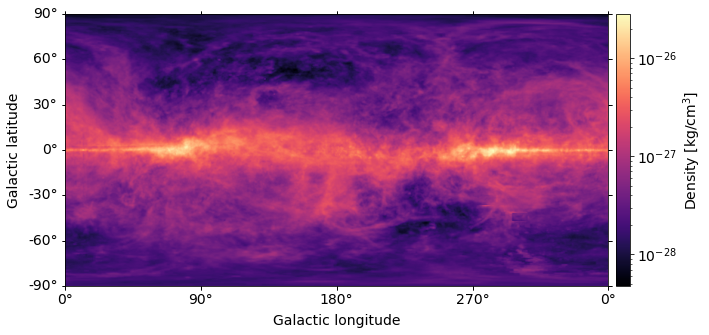

In [8]:
def plot_CO_density(r, save):
    """
    plots CO density for radial bin corresponding to galactocentric radius r
    ****************
    r: [kpc] galactocentric radius
    """
    r_index = bisect.bisect(r_bins, r) - 1 # find radial bin index
    fig = plt.figure(figsize=(10,5))

    wcs = WCS(hdul_CO[0].header)
    wcs_2d = wcs[r_index, :, :]
    ax = plt.subplot(projection=wcs_2d)
    im = ax.imshow(density_data[r_index], cmap='magma', norm=matplotlib.colors.LogNorm())
    ax.set_xlabel('Galactic longitude', fontsize = 14)
    ax.set_ylabel('Galactic latitude', fontsize = 14)
    ax.tick_params(axis="both", labelsize=14) 
    
    X, Y = 0.01, 0.02
    cax = fig.add_axes([ax.get_position().x1 + X, ax.get_position().y0, Y, ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(r'Density [kg/cm$^3$]', size=14)
    cbar.ax.tick_params(labelsize=14)

    if save: 
        plt.savefig('plots/CO_density_r_{}kpc_bin_{}.pdf'.format(r, r_index), bbox_inches="tight")

plot_CO_density(8.5, False)

# rotation curve from Clemens (1985)

In [9]:
# https://articles.adsabs.harvard.edu/pdf/1985ApJ...295..422C
R_0, theta_0 = R_odot, 220 # [kpc], [km/s]
R_i = [0.0, 0.09 * R_0, 0.45 * R_0, 1.6 * R_0, 50.0] # [kpc]; bins for composite curve; see Eq. (5)
# coefficients of rotation curves:
A_i = [0.0, 3069.81, -15809.8, +43980.1, -68287.3, +54904., -17731.] # R/R_0 < 0.09
B_i = [+325.0912, -248.1467, +231.87099, -110.73531, +25.073006, -2.110625] # R/R_0 = 0.09-0.45
C_i = [-2342.6564, +2507.60391, -1024.068760, +224.562732, -28.4080026, +2.0697271, -0.08050808, +0.00129348] # R/R_0 = 0.45-1.6
D_i = [234.88] # R/R_0 > 1.60

dr = 0.1
A_R = np.arange(R_i[0], R_i[1] + dr, dr)
B_R = np.arange(R_i[1], R_i[2] + dr, dr)
C_R = np.arange(R_i[2], R_i[3] + dr, dr)
D_R = np.arange(R_i[3], R_i[4] + dr, dr)

theta_A, theta_B, theta_C, theta_D = np.zeros(len(A_R)), np.zeros(len(B_R)), np.zeros(len(C_R)), np.zeros(len(D_R))
for i in range(len(A_i)):
    theta_A += A_i[i] * A_R**i
for i in range(len(B_i)):
    theta_B += B_i[i] * B_R**i
for i in range(len(C_i)):
    theta_C += C_i[i] * C_R**i
for i in range(len(D_i)):
    theta_D += D_i[i]
    
# radius and rotational velocity, to be used to calculate circular velocity v_circ(r) at any r:
r_rot = [*A_R, *B_R, *C_R, *D_R] # [kpc]
r_rot_unitless = [r / r_s for r in r_rot] # [unitless, in units of r_s]
v_rot = [*theta_A, *theta_B, *theta_C, *theta_D] # [km/s]
v_rot_unitless = [v / (ct.c.to_value(u.km / u.s)) for v in v_rot] # [unitless, in units of c]

# circular velocity interpolating function (~9x faster than putting it in a function)
# v_circ = interp1d(r_rot, v_rot, fill_value='extrapolate') # [km/s]
v_circ_unitless = interp1d(r_rot_unitless, v_rot_unitless, fill_value='extrapolate') # [unitless, in units of c]


def plot_rotation_curves():
    """
    plots rotation curves from Clemens 1985, used for circular baryon velocity
    """
    plt.figure(figsize=(12, 8))
    plt.grid(which = 'both', linestyle = 'dotted')
    plt.xlim(-1, D_R[-1]); plt.ylim(0, 275)
    plt.xlabel('Radius from galactic centre [kpc]', fontsize=14)
    plt.ylabel('Rotation speed [km/s]', fontsize=14)
    plt.plot(A_R, theta_A)
    plt.plot(B_R, theta_B)
    plt.plot(C_R, theta_C)
    plt.plot(D_R, theta_D)
    plt.plot(r_rot, v_rot, color = 'black', linestyle = 'dashed')

# plot_rotation_curves()


# radius & maximum line of sight distance

<center>
    <img src="lineOfSight.PNG" width=500>
</center>

$$\cos\psi = \cos(l)\cos(b)$$

$$  \begin{align}
r &= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} \\
&= \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos b \cos l} 
\end{align} $$
<!-- $$ r = \sqrt{R_\odot^2 + s^2 - 2 R_\odot s \cos \psi} $$ -->

$$ s_\text{max} = (R_\text{halo}^2 - R_\odot^2 \sin^2\psi)^{1/2} + R_\odot \cos\psi $$

In [10]:
def plot_radius_vs_los(b, R_max):
    """
    plots galactic radius as a function of line of sight
    ****************
    b: [deg] galactic latitude
    R_max: [kpc] maximum galactic radius
    """
    # R_max = 50.0 # [kpc]
    plt.figure(figsize = (12, 8))
    plt.grid(which = 'both', linestyle = 'dotted')
    plt.xticks(size = 16); plt.yticks(size=16);
    plt.xlabel(r'Line of sight distance [kpc]', fontsize = 16); plt.ylabel(r'Radius [kpc]', fontsize = 16)
    plt.xlim(0, R_max)
    for l in [0, 5, 15, 30, 90]:
        psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
        s_max = (np.sqrt(R_max * R_max - (R_odot) * (R_odot) * np.sin(psi) * np.sin(psi)) + (R_odot) * np.cos(psi)) # [kpc]
        esses = np.linspace(0, s_max, 400) # [kpc]
        # r = np.sqrt((R_odot/r_s) * (R_odot/r_s) + s**2 - 2 * (R_odot/r_s) * s * np.cos(psi)) # [unitless, in units of r_s]
        arrs = list(map(lambda s: np.sqrt((R_odot) * (R_odot) + s**2 - 2 * (R_odot) * s * np.cos(psi)), esses)) # [kpc]
        plt.plot(esses, arrs, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b))
    plt.plot()
    plt.legend(fontsize=14)
    plt.title('radial coordinate as function of line of sight', fontsize = 20)

# plot_radius_vs_los(b = 0, R_max = 50.0)

# density calculation & interpolation for DM and baryons

The mass density of particle $n \in \{\text{C12}, \text{O16}\}$ is related to the mass density of CO by
$$ \rho_n (r, b, l) = m_n \frac{\rho_\text{CO}(r, b, l)}{m_\text{CO}}. $$

In [11]:
# to convert x from kg/cm^3 to GeV/cm^3: x * (u.kg * (1/u.cm)**3).to_value(u.GeV * (1/u.cm)**3, u.mass_energy())

# dimensionful density interpolator [kg/cm^3], for comparison (~2x faster than putting it in a function)
density_interpolator = []
for i in range(len(r_bins)-1):
    density_interpolator.append(RegularGridInterpolator((bs,ls), density_data[i]))


# unitless density interpolator, in units of rho_s (~2x faster than putting it in a function)
density_unitless_interpolator = []
for i in range(len(r_unitless_bins)-1):
    density_unitless_interpolator.append(RegularGridInterpolator((bs,ls), density_data_unitless[i]))


def density(nucleus, r, b, l):
    """
    returns: [GeV/cm^3] (nucleus, DM) mass density as a function of radius from galactic centre
    **********
    nucleus: 'C12' or 'O16'
    r_kpc: [kpc] radius from galactic centre
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude
    """
    r_index = bisect.bisect(r_bins, r) - 1 # find radial bin index
    rho_DM = rho_s / ( (r/r_s) * (1 + r/r_s)**2 ) # [GeV/cm^3]
    if r >= r_bins[-1]: # if radius is beyond what is provided by GALPROP, return zero for baryon density
        rho_b = 0
        return(rho_b, rho_DM) # ([GeV/cm^3], [GeV/cm^3])

    rho_b = ( nuc_dict[nucleus]['mass [MeV]'] / (nuc_dict['C12']['mass [MeV]'] + nuc_dict['O16']['mass [MeV]']) \
             * density_interpolator[r_index](np.array([b, l]))[0] * (u.kg * (1/u.cm)**3).to_value(u.GeV * (1/u.cm)**3, u.mass_energy()) ) # [GeV/cm^3]
    return (rho_b, rho_DM) # ([GeV/cm^3], [GeV/cm^3])


def density_unitless(nucleus, r, b, l):
    """
    returns: [unitless, in units of rho_s], [unitless, in units of rho_s] (nucleus, DM) mass density as a function of radius from galactic centre
    **********
    nucleus: 'C12' or 'O16'
    r: [unitless, in units of r_s] radius from galactic centre
    b: [degrees] galactic latitude
    l: [degrees] galactic longitude
    """
    r_unitless_index = bisect.bisect(r_unitless_bins, r) - 1 # find unitless radial bin index
    # print(r_unitless_index)
    rho_DM = 1 / ( (r) * (1 + r)**2 ) # [unitless]
    # print(rho_DM * (rho_s * u.GeV * (1/u.cm)**3).to_value())
    if r >= r_unitless_bins[-1]: # if radius is beyond what is provided by GALPROP, return zero for baryon density
        rho_b = 0
        return(rho_b, rho_DM)

    rho_b = (nuc_dict[nucleus]['mass [unitless]'] / (nuc_dict['C12']['mass [unitless]'] + nuc_dict['O16']['mass [unitless]']) \
             * density_unitless_interpolator[r_unitless_index](np.array([b, l])))[0]
    return (rho_b, rho_DM)
        

In [12]:
density_interpolator[2](np.array([0.25, l_crval]))[0]

3.1228803825703367e-27

In [13]:
density('C12', 0.0000001 * r_s, bs[180], l_crval)[0] / (rho_s * u.GeV * (1/u.cm)**3).to_value()


1.957209318206789

In [14]:
density('C12', 0.0000001 * r_s, bs[180], l_crval)[1] / (rho_s * u.GeV * (1/u.cm)**3).to_value()

9999998.000000298

In [15]:
density_unitless('C12', 0.0000001, bs[180], l_crval)

(1.9572092464991977, 9999998.0000003)

In [16]:
def plot_DM_density_vs_los(nucleus, b):
    """
    plots DM density as function of line of sight
    ****************
    nucleus: 'C12' or 'O16'
    b: [deg] galactic latitude
    """
    R_max = 40.0
    plt.figure(figsize = (12, 8))
    plt.grid(which = 'both', linestyle = 'dotted')
    plt.xlabel(r'Line of sight distance [kpc]', fontsize = 16)
    plt.ylabel(r'DM density [GeV/cm$^3$]', fontsize = 16)
    plt.xlim(0, R_max)
    for l in [5.25, 15.25, 30.25, 90.25]:#, 45]:
        psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
        s_max = (np.sqrt(R_max * R_max - (R_odot) * (R_odot) * np.sin(psi) * np.sin(psi)) + (R_odot) * np.cos(psi)) # [kpc]
        esses = np.linspace(0, s_max, 400) # [kpc]
        # r = np.sqrt((R_odot/r_s) * (R_odot/r_s) + s**2 - 2 * (R_odot/r_s) * s * np.cos(psi)) # [unitless, in units of r_s]
        rho_DM = list(map(lambda s: density(nucleus, np.sqrt((R_odot) * (R_odot) + s**2 - 2 * (R_odot) * s * np.cos(psi)), b, l)[1], esses))
        plt.plot(esses, rho_DM, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b))
    plt.plot()
    plt.legend()
    plt.title('dm density as function of line of sight', fontsize = 24)

# plot_DM_density_vs_los(nucleus = 'C12', b = 0.25)


def plot_baryon_density_vs_los(nucleus, b):
    """
    plots baryon density as function of line of sight
    ****************
    nucleus: 'C12' or 'O16'
    b: [deg] galactic latitude
    """
    R_max = 50.0
    fig, ax1 = plt.subplots(figsize = (12, 8))
    ax2 = ax1.twinx()  # create a second axes that shares the same x-axis
    ax1.set_xlabel(r'Line of sight distance [kpc]', fontsize = 16)
    ax1.set_ylabel(r'Baryon density [kg/cm$^3$]', fontsize = 16)
    ax2.set_ylabel(r'Baryon density [GeV/cm$^3$]', fontsize = 16)  # we already handled the x-label with ax1
    ax2.set_xlim(0,35)
    for l in [5.25, 15.25, 30.25, 90.25]:#, 45]:
        psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
        s_max = (np.sqrt(R_max * R_max - (R_odot) * (R_odot) * np.sin(psi) * np.sin(psi)) + (R_odot) * np.cos(psi)) # [kpc]
        esses = np.linspace(0, s_max, 400) # [kpc]
        # r = np.sqrt((R_odot/r_s) * (R_odot/r_s) + s**2 - 2 * (R_odot/r_s) * s * np.cos(psi)) # [unitless, in units of r_s]
        rho_b_GeV = list(map(lambda s: density(nucleus, np.sqrt((R_odot) * (R_odot) + s**2 - 2 * (R_odot) * s * np.cos(psi)), b, l)[0], esses))
        rho_b_kg = list(map(lambda s: density(nucleus, np.sqrt((R_odot) * (R_odot) + s**2 - 2 * (R_odot) * s * np.cos(psi)), b, l)[0] \
                            * 1/(u.kg * (1/u.cm)**3).to_value(u.GeV * (1/u.cm)**3, u.mass_energy()), esses))                     
        ax2.plot(esses, rho_b_GeV, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b), linestyle='dashed', color='black')
        ax1.plot(esses, rho_b_kg, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b))
    plt.plot()
    ax1.legend()
    plt.title('dm density as function of line of sight', fontsize = 24)

# plot_baryon_density_vs_los(nucleus = 'C12', b = 0)


def plot_baryon_density_vs_radius(nucleus, b):
    """
    plots baryon density as function of radius from galactic centre
    ****************
    nucleus: 'C12' or 'O16'
    b: [deg] galactic latitude
    """
    R_max = 50.0
    fig, ax1 = plt.subplots(figsize = (12, 8))
    ax2 = ax1.twinx()  # create a second axes that shares the same x-axis
    ax1.set_xlabel(r'Radius [kpc]', fontsize = 16)
    ax1.set_ylabel(r'Baryon density [kg/cm$^3$]', fontsize = 16)
    ax2.set_ylabel(r'Baryon density [GeV/cm$^3$]', fontsize = 16)  # we already handled the x-label with ax1
    ax2.set_xlim(0,35)
    
    for l in [5.25, 15.25, 30.25, 90.25]:#, 45]:
        arrs = np.linspace(1e-3, R_max, 400)
        rho_b_kg = list(map(lambda arr:density(nucleus, arr, b, l)[0] * 1/(u.kg * (1/u.cm)**3).to_value(u.GeV * (1/u.cm)**3, u.mass_energy()), arrs))
        rho_b_GeV = list(map(lambda arr:density(nucleus, arr, b, l)[0], arrs))
        ax1.plot(arrs, rho_b_kg, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b))
        ax2.plot(arrs, rho_b_GeV, label="(l, b) = ({}$^\circ$, {}$^\circ$)".format(l, b), color='black', linestyle='')
        ax1.legend()
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('baryon density as function of radius from GC', fontsize = 24);

# plot_baryon_density_vs_radius(nucleus = 'C12', b = 0.25)

# velocity dispersions $\sigma(r, \psi)$

In [17]:
def velocity_dispersions_unitless(r):
    """
    returns: [unitless, in units of c] (baryon velocity dispersion, DM velocity dispersion)
    ****************
    r: [unitless, in units of r_s] radius from galactic centre 
    ****************
    DM dispersion function taken from 2111.03076 Figure 1 for r <~ 50 kpc using automeris.io (Distance 76, Delta X = 4 Px, Delta Y = 4 Px)
    """
    disp_b = 10 / (ct.c.to_value(u.km / u.s)) # [unitless, in units of c]
    disp_DM = (-42.9 * np.log(r) + 288.0) / (ct.c.to_value(u.km / u.s)) # [unitless, in units of c]

    return (disp_b, disp_DM)
        

# $v_\text{esc}(r)$

- Compare $v_\text{esc}$ with Figures 2 and 3 of https://ui.adsabs.harvard.edu/abs/2021A%26A...649A.136K/abstract (try https://www.aanda.org/articles/aa/pdf/2018/08/aa33748-18.pdf or https://pure.rug.nl/ws/portalfiles/portal/196810757/aa38777_20.pdf)
- also see https://www.aanda.org/articles/aa/pdf/2018/08/aa33748-18.pdf

In [18]:
# def v_esc(r):
#     """
#     returns: [unitless, in units of r_s] escape velocity as function of [unitless] radius
#     ********
#     r: [unitless, in units of r_s] radius from galactic centre
#     """
#     c_bulge_unitless = c_bulge / r_s
#     b_disk_unitless = b_disk / r_s
#     M_baryon = ((M_bulge * r**2 * (c_bulge_unitless + r)**(-2)) \
#                 + M_disk * (1 - (1 + r/b_disk_unitless) * np.exp(-r/b_disk_unitless)))
#     M_DM = (4 * np.pi * (np.log(1 + r) - r/(1+r)) \
#             * r_s**3 \
#             * (rho_s * u.GeV * (1/u.cm)**3).to_value(u.kg * (1/u.kpc)**3, u.mass_energy()))
#     M_MW = M_baryon + M_DM # [kg]

#     return (np.sqrt(2 * ct.G.to_value() * M_MW / ((r * r_s * u.kpc).to_value(u.m))) \
#             * (u.m * 1/u.s).to_value(u.km * 1/u.s) / (ct.c.to_value(u.km / u.s)))


In [19]:
# def v_esc_paper
# DO THIS LATER

In [20]:
def plot_escape_velocity():
    """
    plots escape velocity as function of radius from galactic centre
    ****************
    """
    plt.figure(figsize=(8, 6))
    plt.grid(which = 'both', linestyle = 'dotted')
    arrs = np.arange(r_rot[0], r_rot[-1], dr)
    plt.xlim(-1, r_rot[-1]); plt.ylim(np.sqrt(2) * v_circ_unitless(arrs[0]/r_s) * ct.c.to_value(u.km / u.s), np.sqrt(2) * 275)
    plt.xlabel('Radius from galactic centre [kpc]', fontsize=14)
    plt.ylabel('Escape velocity [km/s]', fontsize=14)
    plt.plot(arrs, list(map(lambda r: np.sqrt(2) * v_circ_unitless(r/r_s) * ct.c.to_value(u.km / u.s), arrs)), color='black', label='escape velocity')
    plt.plot(r_rot, v_rot, color='black', linestyle='dashed', label='rotation curve')
    plt.legend()
    
# plot_escape_velocity()


# $v_\chi$ integral

In [21]:
def norm_chi(sigma_chi, V_ESC):
    """
    returns: [unitless] normalization factor for DM distribution function;
    !!! CHECK AGAIN with function Int_f_chi(s, b, l) once unitless
    **********
    sigma_chi: [unitless, in units of c] DM velocity dispersion
    V_ESC: [unitless, in units of c] escape velocity
    """
    norm = (2 * np.pi * sigma_chi**2)**(-3/2) * (4 * np.pi) \
    * ( np.sqrt(np.pi / 2) * sigma_chi**3 * scipy.special.erf(V_ESC / (np.sqrt(2) * sigma_chi) ) \
       - sigma_chi**2 * V_ESC * np.exp(- V_ESC**2 / (2 * sigma_chi**2)))
    return norm


def v_chi_integral(m_chi, m_n, dE, r, sigma_chi, V_ESC, v_n):
    """
    returns: [unitless] integral of DM velocity distribution;
    to get unitful dimensions [MeV^-1 km/s] multiply by: (ct.c.to_value(u.km / u.s))/energyScale
    **********
    m_chi: [unitless, in units of energyScale] DM mass
    m_n: [unitless, in units of energyScale] nucleus mass
    dE: [unitless, in units of energyScale] nuclear excitation energy
    r: [unitless, in units of r_s] radius from galactic centre
    sigma_chi: [unitless, in units of c] DM velocity dispersion
    V_ESC: [unitless, in units of c] escape velocity
    v_n: [unitless, in units of c] nucleus velocity
    """
    if (dE - m_chi - (1/2) * m_n * v_n**2) < 0: # process is not possible
        return 0

    # analytical solution for v_chi integral:
    v_chi_plus = np.sqrt( (2 * (dE - m_chi - (1/2) * m_n * v_n**2) ) / (m_chi) ) # [unitless]
    if v_chi_plus > V_ESC:
        return 0
  
    E_chi = ( m_chi + (1/2) * m_chi * v_chi_plus**2 ) # [unitless]
    
    norm = norm_chi(sigma_chi, V_ESC) # [unitless]
    if norm<0:
        print("something has gone wrong!")
        return

    return ( (1 / norm) * (1 / E_chi) * v_chi_plus * np.exp(-v_chi_plus**2 / (2 * sigma_chi**2)) ) # [unitless]

vchiIntegralFactor = (ct.c.to_value(u.km / u.s))/energyScale
# vchiIntegralFactor

# $v_n$ integral

In [22]:
def v_n_integral_bounds(m_chi, m_n, dE, V_ESC):
    """
    returns: [unitless, in units of c] min and max bounds on v_n for baryon distribution function integral
    ****************
    m_chi: [unitless, in units of energyScale] DM mass
    m_n: [unitless, in units of energyScale] nucleus mass
    dE: [unitless, in units of energyScale] nuclear excitation energy
    V_ESC: [unitless, in units of c] escape velocity
    """
    v_n_min = np.sqrt(2 * (dE - m_chi - (1/2) * m_chi * V_ESC**2) / m_n) # [unitless]
    v_n_max = np.sqrt(2 * (dE - m_chi) / m_n) # [unitless]
    
    if v_n_min > V_ESC:
        v_n_min = V_ESC
    if v_n_max > V_ESC:
        v_n_max = V_ESC
    if v_n_min > v_n_max:
        print('v_n bounds make no sense!')
        
    return (v_n_min, v_n_max) # ([unitless, in units of c], [unitless, in units of c])


def norm_n(sigma_b, VBAR, V_ESC):
    """
    returns: [unitless] normalization factor for baryon distribution function;
    !!! CHECK AGAIN with function Int_f_b(s, b, l)
    ****************
    sigma_b: [unitless, in units of c] baryon velocity dispersion
    VBAR: [unitless, in units of c] circular baryon velocity, from Clemens 1985 rotation curves
    V_ESC: [unitless, in units of c] escape velocity
    """
    norm = (2 * np.pi * sigma_b**2)**(-3/2) * (4 * np.pi) \
    * (1/2) * sigma_b * (np.sqrt(2 * np.pi) * (VBAR**2 + sigma_b**2) * scipy.special.erf(VBAR / (np.sqrt(2) * sigma_b)) \
                        - np.sqrt(2 * np.pi) * (VBAR**2 + sigma_b**2) * scipy.special.erf((VBAR - V_ESC) / (np.sqrt(2) * sigma_b)) \
                        + 2 * sigma_b * VBAR * np.exp(- VBAR**2 / (2 * sigma_b**2)) \
                        - 2 * sigma_b * (VBAR + V_ESC) * np.exp(- (VBAR - V_ESC)**2 / (2 * sigma_b**2)) )
    return norm


def v_n_integral(m_chi, m_n, dE, r, sigma_b, sigma_chi):
    """
    returns: [unitless] integral of baryon velocity distribution;
    to get unitful dimensions [MeV^-2 km^4 s^-4] multiply by: energyScale**(-2) * ct.c.to_value(u.km/u.s)**4
    ****************
    m_chi: [unitless, in units of energyScale] DM mass
    m_n: [unitless, in units of energyScale] nucleus mass
    dE: [unitless, in units of energyScale] excitation energy
    r: [unitless, in units of r_s] radius from galactic centre
    sigma_b: [unitless, in units of c] baryon velocity dispersion
    sigma_chi: [unitless, in units of c] DM velocity dispersion
    """
    VBAR = v_circ_unitless(r) # [unitless, in units of c]
    V_ESC = np.sqrt(2) * VBAR # [unitless, in units of c]
    # if VBAR>V_ESC:
    #     return 0
    if (dE - m_chi - (1/2) * m_chi * V_ESC**2) < 0: # square root expression in v_n_min; process is not possible
        return 0

    norm = norm_n(sigma_b, VBAR, V_ESC) # [unitless]
    if norm<0:
        print("something has gone wrong!")
        return
        
    v_n_bounds = v_n_integral_bounds(m_chi, m_n, dE, V_ESC) # ([unitless, in units of c], [unitless, in units of c])
    v_n_min, v_n_max = v_n_bounds[0], v_n_bounds[1] # [unitless, in units of c], [unitless, in units of c]
    
    def f(v_n): 
        # v_n: [unitless]
        E_N = ( m_n + (1/2) * m_n * v_n**2 ) # [unitless]
        integrand = ((2 * np.pi) * (1 / E_N) * sigma_b**2 * (v_n / VBAR) \
        * (np.exp(- (v_n - VBAR)**2 / (2 * sigma_b**2) ) - np.exp(- (v_n + VBAR)**2 / (2 * sigma_b**2) )) \
        * v_chi_integral(m_chi, m_n, dE, r, sigma_chi, V_ESC, v_n))
        return integrand # [unitless]
        
    integral, err = quad(f, v_n_min, v_n_max) # integration gives factor of [unitless, in units of c]
    return (1/norm) * integral # [unitless]

vnIntegralFactor = vchiIntegralFactor * energyScale**(-1) * ct.c.to_value(u.km/u.s)**3
# vnIntegralFactor

In [23]:
# def plot_f_v_N(m_chi, m_n, deltaE):
#     """
#     !!!
#     Introducing baryon bulk velocity as a function of radius (v_circ(r)) increases the flux by orders of magnitude depending on the radius.
    
#     !!!
#     """
#     plt.figure(figsize=(8, 6))
#     for r in [7, 8.5, 9, 10]:
#         if m_chi > deltaE: # process not possible
#             return 0
    
#         VBAR = v_circ(r) # [km/s]
#         V_ESC = np.sqrt(2) * VBAR #v_esc(r) # [km/s]
#         # if VBAR>V_ESC:
#         #     return 0
#         if (deltaE - m_chi - (1/2) * m_chi * (V_ESC/(c/1000))**2) < 0: # v_N_min expression
#             return 0
        
#         sigma_b = velocity_dispersions(r)[0] # [km/s]
#         norm = norm_n(VBAR, V_ESC, sigma_b)
#         if norm<0:
#             return
            
#         v_N_bounds = v_N_integral_bounds(m_chi, m_n, deltaE, V_ESC)
#         v_N_min, v_N_max = v_N_bounds[0], v_N_bounds[1] # [km/s], [km/s]
#         vees = np.linspace(v_N_min, v_N_max, 100)
    
#         def f(v_n):
#             V_N = v_n / (c/1000) # convert from km/s to unitless
#             E_N = ( m_n + (1/2) * m_n * V_N**2 ) # [MeV]
#             integrand = ((2 * np.pi) * (1 / E_N) * sigma_b**2 * (v_n / VBAR) \
#             * (np.exp(- (v_n - VBAR)**2 / (2 * sigma_b**2) ) - np.exp(- (v_n + VBAR)**2 / (2 * sigma_b**2) )) \
#             * v_chi_integral(m_chi, m_n, deltaE, r, v_n))
#             # [MeV^-1] * [km/s]^2  *  [unitless]  *  [MeV^-1 km/s]
#             return 1/norm * integrand # [MeV^-2 * km^3/s^3]

#         norm220 = norm_n(220, V_ESC, sigma_b)
#         def f_220(v_n):
#             V_N = v_n / (c/1000) # convert from km/s to unitless
#             E_N = ( m_n + (1/2) * m_n * V_N**2 ) # [MeV]
#             integrand = ((2 * np.pi) * (1 / E_N) * sigma_b**2 * (v_n / 220) \
#             * (np.exp(- (v_n - 220)**2 / (2 * sigma_b**2) ) - np.exp(- (v_n + 220)**2 / (2 * sigma_b**2) )) \
#             * v_chi_integral(m_chi, m_n, deltaE, r, v_n))
#             # [MeV^-1] * [km/s]^2  *  [unitless]  *  [MeV^-1 km/s]
#             return 1/norm220 * integrand # [MeV^-2 * km^3/s^3]
        
#         plt.plot(vees[1:-2], list(map(lambda vee: f(vee)/f_220(vee), vees[1:-2])), label='r = {}'.format(r))
#         # plt.plot(vees, list(map(lambda vee: f(vee), vees)), label='r = {}'.format(r))
#         # plt.plot(vees, list(map(lambda vee: f_220(vee), vees)), label='r = {}'.format(r), linestyle = 'dashed', color='black')
#     plt.xlim(vees[1], vees[-2])
#     plt.xlabel('Baryon velocity [km/s]', fontsize = 14); plt.ylabel(r'Ratio of dist. functions: $\bar{v}(r)$ vs $\bar{v} = 220$ km/s', fontsize = 14)
#     # plt.xlabel('Baryon velocity [km/s]'); plt.ylabel('Dist. functions', fontsize = 14)
#     plt.legend()
#     return

# plot_f_v_N(m_chi = 16.72997316197439, m_n = nuc_dict['O16']['mass [MeV]'], deltaE = 16.732241)

# line of sight integral

In [24]:
def line_of_sight_integral(m_chi, nucleus, m_n, dE, b, l, R_max):
    """
    returns: [unitless] line of sight integral;
    to get unitful dimensions [cm^-5] multiply by losIntegralFactor:
        (rho_s * rho_s * ct.c.to_value(u.km/u.s)**(-6)) * energyScale**(-2) * ct.c.to_value(u.km/u.s)**4 \
        * ct.c.to_value(u.km/u.s)**2 * 1000**2 * (1 * u.kpc).to_value(u.cm)
    ****************
    m_chi: [unitless, in units of energyScale] DM mass
    nucleus: 'C12' or 'O16'
    m_n: [unitless, in units of energyScale] nucleus mass
    dE: [unitless, in units of energyScale] excitation energy
    b: [deg] galactic latitude
    l: [deg] galactic longitude
    R_max: [unitless, in units of r_s] maximum galactic radius
    """
    psi = np.arccos( np.cos(np.radians(b)) * np.cos(np.radians(l)) ) # [radians]
    s_max = (np.sqrt(R_max * R_max - (R_odot/r_s) * (R_odot/r_s) * np.sin(psi) * np.sin(psi)) + (R_odot/r_s) * np.cos(psi)) # [unitless, in units of r_s]
        
    def f(s):
        # s: [unitless, in units of r_s]
        r = np.sqrt((R_odot/r_s) * (R_odot/r_s) + s * s - 2 * (R_odot/r_s) * s * np.cos(psi)) # [unitless, in units of r_s]

        disp = velocity_dispersions_unitless(r) # ([unitless, in units of c], [unitless, in units of c])
        sigma_b, sigma_chi = disp[0], disp[1] # [unitless, in units of c], [unitless, in units of c]
        
        V_N_integral = v_n_integral(m_chi, m_n, dE, r, sigma_b, sigma_chi) # [unitless]
        if V_N_integral == 0:
            return 0 # save time
        
        rho = density_unitless(nucleus, r, b, l) # ([unitless, in units of rho_s], [unitless, in units of rho_s])
        rho_b, rho_chi = rho[0], rho[1] # [unitless, in units of rho_s], [unitless, in units of rho_s]
        integrand = rho_b * rho_chi * ((2 * np.pi) * sigma_b * sigma_chi)**(-3) * V_N_integral
        return integrand

    esses = np.linspace(0, s_max, 2000) # [unitless, in units of r_s]
    g = list(map(lambda ess: f(ess), esses))
    integral = cumtrapz(g, esses, initial=0) # [unitless], integral gives factor of [unitless, in units of r_s]
    return integral[-1] # unitless


losIntegralFactor = (rho_s * rho_s * ct.c.to_value(u.km/u.s)**(-6)) * vnIntegralFactor * ct.c.to_value(u.km/u.s)**2 * 1000 * 1000 * (1 * u.kpc).to_value(u.cm)
# 1000 * 1000 converts rho_s * rho_s to [MeV/cm^3] * [MeV/cm^3]
losIntegralFactor

8.025847389459045e+24

# flux

In [25]:
def diff_flux_w_convolution_for_single_dE(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b, l, R_max, epsilon, E):
    """
    returns: [unitless] differential flux;
    to get unitful dimensions [cm^-2 s^-1 MeV^-1 sr^-1] multiply by fluxFactor:
        ( 1/energyScale * 1/energyScale \
         * losIntegralFactor \
         * 1/energyScale \
         * (ct.c.to_value(u.cm/u.s)) * (ct.hbar.to_value(u.MeV * u.s) * ct.c.to_value(u.cm/u.s))**2 )
    ****************
    g_chi: [unitless, in units of 1/energyScale] DM-nucleus coupling constant
    m_chi: [unitless, in units of energyScale] DM mass
    nucleus: 'C12' or 'O16'
    m_n: [unitless, in units of energyScale] nucleus mass
    J_n: [unitless] nucleus spin
    dE: [unitless, in units of energyScale] excitation energy
    GT: [unitless] GT strength for excitation energy dE
    b: [deg] galactic latitude
    l: [deg] galactic longitude
    R_max: [unitless, in units of r_s] maximum galactic radius
    epsilon: [unitless] energy resolution
    E: [unitless, in units of energyScale] observed photon energy
    """
    fluxes, flux_tot = [], 0
    
    # do some checks to save time:
    if m_chi > dE:
        print("m_chi > dE")
        # flux_tot = 0
        return flux_tot
    
    expTerm = np.exp(-(E - dE)**2 / (2 * epsilon**2 * dE**2))
    if expTerm == 0:
        print("expTerm == 0")
        # flux_tot = 0
        return flux_tot
    
    los_integral = line_of_sight_integral(m_chi, nucleus, m_n, dE, b, l, R_max) # [unitless] 
    # multiply los_integral by losIntegralFactor to get [cm^-5]
    if los_integral == 0:
        print("los == 0")
        # flux_tot = 0
        return flux_tot

    R = (np.sqrt(2 * np.pi) * epsilon * dE)**(-1) * expTerm # [unitless], needs to be multiplied by 1/energyScale to get [MeV^-1]
    flux = ((1/24 * g_chi * g_chi * g_A * g_A / (2*J_n + 1)) * (m_n + dE)/m_n * los_integral * GT * R) # [unitless]
    fluxes.append(flux)
    flux_tot += flux

    return flux_tot # [unitless]


fluxFactor = ( 1/energyScale * 1/energyScale \
              * losIntegralFactor \
              * 1/energyScale \
              * (ct.c.to_value(u.cm/u.s)) * (ct.hbar.to_value(u.MeV * u.s) * ct.c.to_value(u.cm/u.s))**2 )
# fluxFactor


In [26]:
#     create folder for each dE energy, for flux data
#     **** has already been run ****
#     """
#     from pathlib import Path
#     for nuc in ['C12', 'O16']:
#         for dE in nuc_dict[nuc]['dEs [MeV]']:
#             Path("differential_flux_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)
#             Path("b_integral_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)
#             Path("solid_angle_integral_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)

In [31]:
def b_integral(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b_min, b_max, l, R_max, epsilon, E):
    """
    returns: [unitless * rad] differential flux integrated over galactic latitude from b_min to b_max
    ****************
    g_chi: [unitless, in units of 1/energyScale] DM-nucleus coupling constant
    m_chi: [unitless, in units of energyScale] DM mass
    nucleus: 'C12' or 'O16'
    m_n: [unitless, in units of energyScale] nucleus mass
    J_n: [unitless] nucleus spin
    dE: [unitless, in units of energyScale] excitation energy
    GT: [unitless] GT strength for excitation energy dE
    b_min: [deg] lower integral bound for galactic latitude
    b_max: [deg] upper integral bound for galactic latitude
    l: [deg] galactic longitude
    R_max: [unitless, in units of r_s] maximum galactic radius
    epsilon: [unitless] energy resolution
    E: [unitless, in units of energyScale] observed photon energy
    """
    diffFlux = []

    def f(b):
        # b: [deg]
        print("        b = {} deg".format(b))
        x = diff_flux_w_convolution_for_single_dE(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b, l, R_max, epsilon, E) # [unitless]
        print("            differential flux [cm^-2 s^-1 MeV^-1 sr^-1]: {}".format(x * fluxFactor))
        diffFlux.append(x * fluxFactor)
        integrand = np.sin(b * np.pi/180 + np.pi/2) * x  # [unitless]
        # sine argument accounts for transformation from GALPROP convention to standard solid angle convention
        return integrand # [unitless]
    bees = np.linspace(b_min, b_max, 20) # 20; testing: use 3
    g = list(map(lambda bee: f(bee), bees))
    integral = cumtrapz(g, bees, initial=0) # [deg]

    #### write differential flux to file for each value of b ####
    Path("data/differential_flux_data_by_dE/{}/{}MeV".format(nucleus, dE*energyScale)).mkdir(parents=True, exist_ok=True)
    filename = 'data/differential_flux_data_by_dE/{}/{}MeV/m_chi_{}MeV_l_{}deg_epsilon_{}.txt'.format(nucleus, dE*energyScale, m_chi*energyScale, l, 100*epsilon)
    metadata = "# R_odot [kpc] = {}, \n\
# R_max [kpc] = {} kpc\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# GT = {}\n#\n".format(R_odot, R_max*r_s, rho_s, r_s, g_chi/energyScale, g_A, GT)
    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'b [deg]': bees, 'Differential flux [cm^-2 s^-1 MeV^-1 sr^-1]': diffFlux}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a')
    ################
    
    return integral[-1] * np.pi/180 # [deg] -> [rad]


def l_integral(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b_min, b_max, l_min1, l_max1, l_min2, l_max2, R_max, epsilon, E):
    """
    returns: [unitless * rad * rad] (flux1, flux2) integrated over galactic latitude from b_min to b_max, and:
        flux1: galactic longitude from l_min1 to l_max1
        flux2: galactic longitude from l_min2 to l_max2 
    ****************
    g_chi: [unitless, in units of 1/energyScale] DM-nucleus coupling constant
    m_chi: [unitless, in units of energyScale] DM mass
    nucleus: 'C12' or 'O16'
    m_n: [unitless, in units of energyScale] nucleus mass
    J_n: [unitless] nucleus spin
    dE: [unitless, in units of energyScale] excitation energy
    GT: [unitless] GT strength for excitation energy dE
    b_min: [deg] lower integral bound for galactic latitude
    b_max: [deg] upper integral bound for galactic latitude
    l_min1: [deg] lower bound for first galactic longitude integral
    l_max1: [deg] upper bound for first galactic longitude integral
    l_min2: [deg] lower bound for second galactic longitude integral
    l_max2: [deg] upper bound for second galactic longitude integral
    R_max: [unitless, in units of r_s] maximum galactic radius
    epsilon: [unitless] energy resolution
    E: [unitless, in units of energyScale] observed photon energy
    """
    bInt = []
    def f(l):
        # l: [deg]
        print("    l = {} deg".format(l))
        integrand = b_integral(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b_min, b_max, l, R_max, epsilon, E) # [rad]
        bInt.append(integrand * fluxFactor)
        return integrand

    ells1 = np.linspace(l_min1, l_max1, 60) # 60; testing: use 3
    g1 = list(map(lambda ell1: f(ell1), ells1))
    integral1 = cumtrapz(g1, ells1, initial=0) # [rad] * [deg]

    ells2 = np.linspace(l_min2, l_max2, 60) # 60; testing: use 3
    g2 = list(map(lambda ell2: f(ell2), ells2))
    integral2 = cumtrapz(g2, ells2, initial=0) # [rad] * [deg]
    # integral = integral1[-1] + integral2[-1]

    #### write differential flux (integrated over b) to file for each value of l ####
    Path("data/b_integral_data_by_dE/{}/{}MeV".format(nucleus, dE*energyScale)).mkdir(parents=True, exist_ok=True)
    filename = 'b_integral_data_by_dE/{}/{}MeV/m_chi_{}MeV_epsilon_{}.txt'.format(nucleus, dE*energyScale, m_chi*energyScale, 100*epsilon)
    metadata = "# b range [deg] = [{}, {}], \n\
# R_odot [kpc] = {}, \n\
# R_max [kpc] = {} kpc\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# GT = {}\n#\n".format(b_min, b_max, R_odot, R_max*r_s, rho_s, r_s, g_chi/energyScale, g_A, GT)
    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'l [deg]': [*ells1, *ells2], 'Differential flux [cm^-2 s^-1 MeV^-1 rad^-1]': bInt}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a')
    ################
    
    return (integral1[-1] * np.pi/180, integral2[-1] * np.pi/180) # ([rad * rad], [rad * rad])


def solid_angle_integral(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b_min, b_max, l_min1, l_max1, l_min2, l_max2, integratedSolidAngle, R_max, epsilon):
    """
    returns: [unitless] solid-angle-averaged flux integrated over:
        galactic latitude from b_min to b_max
        galactic longitude from l_min1 to l_max1
        galactic longitude from l_min2 to l_max2 
    ****************
    g_chi: [unitless, in units of 1/energyScale] DM-nucleus coupling constant
    m_chi: [unitless, in units of energyScale] DM mass
    nucleus: 'C12' or 'O16'
    m_n: [unitless, in units of energyScale] nucleus mass
    J_n: [unitless] nucleus spin
    dE: [unitless, in units of energyScale] excitation energy
    GT: [unitless] GT strength for excitation energy dE
    b_min: [deg] lower integral bound for galactic latitude
    b_max: [deg] upper integral bound for galactic latitude
    l_min1: [deg] lower bound for first galactic longitude integral
    l_max1: [deg] upper bound for first galactic longitude integral
    l_min2: [deg] lower bound for second galactic longitude integral
    l_max2: [deg] upper bound for second galactic longitude integral
    R_max: [unitless, in units of r_s] maximum galactic radius
    epsilon: [unitless] energy resolution
    """
    
    # observed photon energy spectrum; currently using 1 sigma:
    energy = np.linspace((dE - 1 * epsilon * dE), (dE + 1 * epsilon * dE), 11) # [unitless, in units of energyScale]
    # for testing:
    # [nuc_dict['C12']['dEs [MeV]'][0]/energyScale] # [unitless, in units of energyScale]
    energyMeV = [EE * energyScale for EE in energy] # [MeV] used for datafile
    
    integratedFlux1, integratedFlux2 = [], []
    integratedFlux = []
    
    for E in energy: # [unitless, in units of energyScale]
        print("    observed photon energy = {} MeV".format(E*energyScale))
        intFlux1, intFlux2 = l_integral(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, \
                                        b_min, b_max, l_min1, l_max1, l_min2, l_max2, R_max, epsilon, E) # [rad * rad], [rad * rad]
        integratedFlux1.append(intFlux1 * fluxFactor) # [rad * rad] * [cm^-2 s^-1 MeV^-1 sr^-1] = [cm^-2 s^-1 MeV^-1]
        integratedFlux2.append(intFlux2 * fluxFactor) # [rad * rad] * [cm^-2 s^-1 MeV^-1 sr^-1] = [cm^-2 s^-1 MeV^-1]
        integratedFlux.append((intFlux1 + intFlux2) * fluxFactor) # [cm^-2 s^-1 MeV^-1]

    #### calculate solid-angle-averaged-flux ####
    averagedFlux = [i / integratedSolidAngle for i in integratedFlux] # [cm^-2 s^-1 MeV^-1 sr^-1]
    ################
    
    #### write to file ####
    Path("data/solid_angle_integral_data_by_dE/{}/{}MeV".format(nucleus, dE*energyScale)).mkdir(parents=True, exist_ok=True)
    filename = 'data/solid_angle_integral_data_by_dE/{}/{}MeV/m_chi_{}MeV_epsilon_{}.txt'.format(nucleus, dE*energyScale, m_chi*energyScale, 100*epsilon)
    metadata = "# Integral 1 l bounds [deg] = [{}, {}], \n\
# Integral 2 l bounds [deg] = [{}, {}], \n\
# b range [deg] = [{}, {}], \n\
# R_odot [kpc] = {}, \n\
# R_max [kpc] = {} kpc\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# GT = {}\n#\n".format(l_min1, l_max1, l_min2, l_max2, b_min, b_max, R_odot, R_max*r_s, rho_s, r_s, g_chi/energyScale, g_A, GT)
    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'Photon energy [MeV]': energyMeV, 'Solid-angle-averaged flux [cm^-2 s^-1 MeV^-1 sr^-1]': averagedFlux, 'Integrated flux [cm^-2 s^-1 MeV^-1]': integratedFlux, \
           'Integral 1 [cm^-2 s^-1 MeV^-1]': integratedFlux1, 'Integral 2 [cm^-2 s^-1 MeV^-1]': integratedFlux2}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a') 
    ################


# if __name__=="__main__":
def main():
    nucleus = 'C12'
    g_chi = 1 # [MeV^-1]
    R_max = 50.0 # [kpc]
    epsilon = 0.05 # [unitless]
    m_n, J_n = nuc_dict[nucleus]['mass [unitless]'], nuc_dict[nucleus]['spin'] # [unitless, in units of energyScale], [unitless]
    l_min1, l_max1 = 330.25, ls[-1] # [deg], [deg]; bounds for first galactic longitude integral
    l_min2, l_max2 = ls[0], 29.75 # [deg], [deg]; bounds for second galactic longitude integral
    b_min, b_max = -4.75, 4.75 # [deg], [deg]; bounds for galactic latitude integral

    #### integrate solid angle, for calculating solid-angle-averaged flux ####
    def f(b, l):
        integrand = np.sin(b * np.pi/180 + np.pi/2)
        return integrand # [unitless]
        
    integratedSolidAngle1 = dblquad(f, l_min1, l_max1, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle2 = dblquad(f, l_min2, l_max2, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle = integratedSolidAngle1 + integratedSolidAngle2 # [sr]
    print("integrated solid angle (flux denominator): {} sr".format(integratedSolidAngle))
    ################
    
    print(nucleus)
    for dE in nuc_dict[nucleus]['dEs [MeV]'][5:80:10]: # for now, only go to 80 for C12, 75 for O16
        i = list(nuc_dict[nucleus]['dEs [MeV]']).index(dE)
        GT = nuc_dict[nucleus]['GTs'][i] # [unitless]
        print("i = {}:    dE = {} MeV, GT = {}".format(i, dE, GT))

        # # retrieve DM masses that maximize the v_n_integral for a given dE:
        # mass_by_dE_data = 'optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nucleus, nucleus, dE)
        # mass_by_dE_df = pd.read_csv(mass_by_dE_data, sep='\t', names=['Radius from GC [kpc]', 'Optimal DM mass [MeV]'], skiprows=1)
        # M_CHIS = mass_by_dE_df['Optimal DM mass [MeV]']
        # dm = (np.max(M_CHIS) - np.min(M_CHIS))/2
        # m_chis = np.linspace(np.min(M_CHIS) - dm, np.max(M_CHIS) + dm, 5)
ouy#     print("    m_chi = {} MeV".format(m_chi))
        #     solid_angle_integral(g_chi*energyScale, m_chi/energyScale, nucleus, m_n, J_n, dE/energyScale, GT, b_min, b_max, l_min1, l_max1, l_min2, l_max2, integratedSolidAngle, R_max/r_s, epsilon)

main()


integrated solid angle (flux denominator): 0.17054255251399486 sr
C12
i = 5:    dE = 20.634644 MeV, GT = 0.005098
i = 15:    dE = 23.975631 MeV, GT = 0.002376
i = 25:    dE = 27.125878000000004 MeV, GT = 0.009181
i = 35:    dE = 30.851649 MeV, GT = 0.003359
i = 45:    dE = 34.993877000000005 MeV, GT = 0.005833
i = 55:    dE = 39.565449 MeV, GT = 0.001894
i = 65:    dE = 44.525012 MeV, GT = 0.000757
i = 75:    dE = 49.82493 MeV, GT = 0.000234


In [ ]:
/Users/arm5765/Desktop/git/DM-nucleus-inelastic-ID/differential_flux_data_by_dE/C12/32.792416MeV
/Users/arm5765/Desktop/git/DM-nucleus-inelastic-ID/data/differential_flux_data_by_dE/C12/3.2792416MeV

In [ ]:
xlist = []
def test():
    return (1, 1)

x, y = test()
print(x)
xlist.append(x * 3)
xlist

In [ ]:

nucleus = 'C12'
dE = nuc_dict['C12']['dEs [MeV]'][0]
mass_by_dE_data = 'optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nucleus, nucleus, dE)
mass_by_dE_df = pd.read_csv(mass_by_dE_data, sep='\t', names=['Radius from GC [kpc]', 'Optimal DM mass [MeV]'], skiprows=1)
m_chis = mass_by_dE_df['Optimal DM mass [MeV]']

dm = (np.max(m_chis) - np.min(m_chis))/2
print(round(np.max(m_chis) - np.min(m_chis),3))

np.linspace(np.min(m_chis) - dm, np.max(m_chis) + dm, 5)[1]
# np.min(m_chis)

In [ ]:
print("# GT = {}\n\n")
print("hi")

In [ ]:

nucleus = 'C12'
for i in range(len(radial_array(N=5))):
    dE = nuc_dict['C12']['dEs [MeV]'][i]
    mass_by_dE_data = 'optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nucleus, nucleus, dE)
    mass_by_dE_df = pd.read_csv(mass_by_dE_data, sep='\t', names=['Radius from GC [kpc]', 'Optimal DM mass [MeV]'], skiprows=1)
    m_chis = mass_by_dE_df['Optimal DM mass [MeV]']
    print(np.max(m_chis) - np.min(m_chis))

In [ ]:
round(np.mean(m_chis), 3)
# m_chis_test = 

In [ ]:
def radial_array(N):
    """
    returns: [kpc] radial array with N-2 additional points in each radial bin;
    made up of equally spaced arrays of length N for each radial bin;
    radial array is used to find optimal DM masses that maximize the baryon velocity distribution integral
    """
    rr_bins = [0.0000001, *r_bins[1:]] # non-zero start, set at smallest decimal place of r_bins
    rr_array = []
    for i in range(len(rr_bins)-1):
        rr_array.append(np.linspace(rr_bins[i], rr_bins[i+1], N)[:-1])
    rr_array.append(r_bins[-1])
    rr_array = np.hstack(rr_array)
    return rr_array

# radial_array(N = 5)


def negative_v_n_integral(m_chi, m_n, dE, r, sigma_b, sigma_chi):
    """
    m_chi: [unitless, in units of energyScale]
    m_n: [unitless, in units of energyScale]
    dE: [unitless, in units of energyScale]
    r: [unitless, in units of r_s]
    sigma_b: [unitless, in units of c]
    sigma_chi: [unitless, in units of c]
    """
    return np.negative(v_n_integral(m_chi, m_n, dE, r, sigma_b, sigma_chi))


def maximize_v_n_integral(nucleus, dE, r):
    """
    returns: [unitless, in units of energyScale] DM mass that maximizes v_n_integral
    ****************
    nucleus: 'C12' or 'O16'
    dE: [MeV] nuclear excitation energy
    r: [kpc] radius from galactic centre
    """
    # m_chi_initialGuess = 16#np.arange(deltaE - 1/10, deltaE, 1e-2)
    # print(m_chi_initialGuess)
    disp = velocity_dispersions_unitless(r) # ([unitless, in units of c], [unitless, in units of c])
    sigma_b, sigma_chi = disp[0], disp[1] # [unitless, in units of c], [unitless, in units of c]
    
    m_chi = minimize_scalar(negative_v_n_integral, bounds=((dE-1/10)/energyScale, dE/energyScale), \
                   args=(nuc_dict[nucleus]['mass [unitless]'], dE/energyScale, r/r_s, sigma_b, sigma_chi))
    return(m_chi.x) # [unitless]

# np.negative(v_n_integral(m_chi = 16.73, m_n = nuc_dict['O16']['mass [MeV]'], deltaE = 16.732241, r = 10))
# print(maximize_v_n_integral('O16', 16.732240999999995, 10))


def optimal_m_chis_by_r(r):
    """
    creates .txt files of optimal m_chis for all C12, O16 excitation energies as function of radius
    files have already been generated, no need to run function...
    UNLESS any of the main functions are changed
    - was rerun after normalization factor fixed
    """
    for nuc in ['C12', 'O16']:
        m_chis = []
        for dE in nuc_dict[nuc]['dEs [MeV]']:
            m_chis.append(maximize_v_n_integral(nuc, dE, r) * energyScale) # [MeV]
            
        dat = {'Nuclear excitation energy [MeV]': nuc_dict[nuc]['dEs [MeV]'], 'Optimal DM mass [MeV]': m_chis}
        df = pd.DataFrame(dat)
        df.to_csv('optimal_m_chis_by_r/{}/{}_optimal_m_chis_r_{}kpc.txt'.format(nuc, nuc, r), sep='\t', index=False)
    return

# for r in radial_array(N = 5):
#     optimal_m_chis_by_r(r)


def optimal_m_chis_by_dE(arrs, save):
    """
    creates .txt files of optimal m_chis for all C12, O16 excitation energies for each excitation energy 
    files have already been generated, no need to run function...
    UNLESS any of the main functions are changed
    or you want to include additional radii
    - was rerun after normalization factor fixed
    """
    for nuc in ['C12', 'O16']:
        m_chis = [[] for _ in range(len(nuc_dict[nuc]['dEs [MeV]']))]
        for i in range(len(nuc_dict[nuc]['dEs [MeV]'])):
            for j in range(len(arrs)):
                # print(arrs[j])
                mass_by_r_data = 'optimal_m_chis_by_r/{}/{}_optimal_m_chis_r_{}kpc.txt'.format(nuc, nuc, arrs[j])
                mass_by_r_df = pd.read_csv(mass_by_r_data, sep='\t', names=['Nuclear excitation energy [MeV]',	'Optimal DM mass [MeV]'], skiprows=1)
                m_chis[i].append(mass_by_r_df['Optimal DM mass [MeV]'][i])

        if save:
            mass_by_dE_data = {'Radius from GC [kpc]': arrs, 'Optimal DM mass [MeV]': m_chis[i]}
            mass_by_dE_df = pd.DataFrame(mass_by_dE_data)
            mass_by_dE_df.to_csv('optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nuc, nuc, nuc_dict[nuc]['dEs [MeV]'][i]), sep='\t', index=False)
        return m_chis

# optimal_m_chis_by_dE(radial_array(N = 5), False)
len(radial_array(N=5))

In [ ]:
i = list(nuc_dict['C12']['dEs [MeV]']).index(E)
print(i)

In [ ]:
nuc_dict['C12']['dEs [MeV]'][2:-1:10]

In [ ]:
def main2():

    """
    THIS IS A LATER PROBLEM
    """
    
    #
    dE = 52.579828000000006 # C12
    
    
    for i in [52.579828000000006, 52.577086]:
        dE = i

        C12_flux = 

    # the C12 DM masses that excite dE(C12) = 52.579828000000006 also excite dE(O16) = 52.577086
    # the C12 DM masses that excite dE(C12) = 72.791594 also excite dE(O16) = 72.79192099999999

    # the O16 DM masses that excite dE(O16) = 72.79192099999999 also excite dE(C12) = 72.791594
    
    # optimal C12 masses that excite both C12 and O16:
    # [52.579828000000006, 52.577086] # [C12 dE, O16 dE]
    # [72.791594, 72.79192099999999] # [C12 dE, O16 dE]

    # optimal O16 masses that excite both C12 and O16:
    # [72.791594, 72.79192099999999] # [C12 dE, O16 dE]

In [ ]:
main()

In [ ]:
def f(b, l):
    integrand = np.sin(b * np.pi/180 + np.pi/2)
    return integrand
integratedSolidAngle1 = dblquad(f, 330.25, ls[-1], -4.75, 4.75)[0] * np.pi/180 * np.pi/180 # [sr]
integratedSolidAngle2 = dblquad(f, ls[0], 29.75, -4.75, 4.75)[0] * np.pi/180 * np.pi/180 # [sr]
integratedSolidAngle = integratedSolidAngle1 + integratedSolidAngle2
print(integratedSolidAngle)

In [ ]:
def f(b, l):
    integrand = np.sin(b * np.pi/180 + np.pi/2)
    return integrand
integrateSolidAngle1 = dblquad(f, 330.25-360, 29.75, -4.75, 4.75)[0] * np.pi/180 * np.pi/180 # [sr]
integrateSolidAngle2 = 0#dblquad(f, ls[0], 29.75, -4.75, 4.75)[0] * np.pi/180 * np.pi/180 # [sr]
integrateSolidAngle = integrateSolidAngle1 + integrateSolidAngle2
print(integrateSolidAngle)

In [ ]:
def f(b, l):
    integrand = np.sin(b * np.pi/180 + np.pi/2)
    return integrand
integral = dblquad(f, 330.25-360, 329.75, -90, 90)[0] * np.pi/180 * np.pi/180 # [unitless]
    
print(integral)


In [ ]:
#bIntegral(1, m_chis_C12[3], 'C12', -4.75, 4.75, l_crval, 50.0, 0.1, nuc_dict['C12']['dEs [MeV]'][3])
#lIntegral(1, m_chis_C12[3], 'C12', -4.75, 4.75, 330.25, ls[-1], ls[0], 29.75, 50.0, 0.1, nuc_dict['C12']['dEs [MeV]'][3])
integrateSolidAngleFlux(1, m_chis_C12[0], 'C12', 2*R_odot, 0.1) # energy = [nuc_dict['C12']['dEs [MeV]'][0]]
# IntS|olidAngleFluxAllCOMasses(1, 2*R_odot, 0.10)


In [ ]:
def fluxData(g_chi, m_chi, nucleus, b, l, R_max, epsilon):
    """
    Calculates flux and writes to .txt file.
    ****************
    g_chi: [unitless]
    m_chi: [unitless, in units of energyScale]
    nucleus: 'C12' or 'O16'
    b: [deg]
    l: [deg]s
    R_max: [unitless, in units of r_s]
    epsilon: [unitless] % of convolution as decimal from 0 to 1
    """
    m_n, J_n = nuc_dict[nucleus]['mass [unitless]'], nuc_dict[nucleus]['spin']
    dEs = nuc_dict[nucleus]['dEs [MeV]'] / energyScale
    GTs = nuc_dict[nucleus]['GT']
    nucl_exc = list(zip(dEs, GTs))
    GT_sum = np.sum(GTs)
    flux_tot = []
    energy = np.linspace((m_chi - 5 * epsilon * m_chi), (m_chi + 5 * epsilon * m_chi), 21)
    flux_tot = [(flux_w_convolution(g_chi * energyScale, m_chi / energyScale, \
                                   nucleus, m_n, J_n, b, l, R_max / r_s, epsilon, \
                                   nucl_exc, GT_sum, E / energyScale) * fluxFactor) for E in energy]
    # for E in energy:
    #     # print(E)
    #     flux_tot.append(flux_w_convolution(g_chi * energyScale, m_chi / energyScale, \
    #                                nucleus, m_n, J_n, b, l, R_max / r_s, epsilon, \
    #                                nucl_exc, GT_sum, E / energyScale) * fluxFactor)

    filename = 'fluxData/{}/mchi_{}MeV_l_{}deg_b_{}deg_epsilon_{}.txt'.format(nucleus, m_chi, l, b, 100*epsilon)
    metadata = "# R_odot [kpc] = {}, \n\
# R_max [kpc] = {} kpc\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n\
# M_bulge [solar masses] = {}\n\
# c_bulge [kpc] = {}\n\
# M_disk [solar masses] = {}\n\
# b_disk [kpc] = {}\n\
# g_A = {}\n\n".format(R_odot, R_max, rho_s, r_s, M_bulge, c_bulge, M_disk, b_disk, g_A)

    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'Photon energy [MeV]': energy, '{} flux [cm^-2 s^-1 sr^-1 MeV^-1]'.format(nucleus): flux_tot}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a')
    return flux_tot


In [ ]:
# def plotFlux(g_chi, m_chi, nucleus, b, l, R_max, epsilon, save):
#     """
#     plots from .txt file
#     """
#     df = pd.read_csv('fluxData/{}/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(nucleus, m_chi, b, l, R_max, 100*epsilon),\
#                      sep='\t', \
#                      names=['Photon energy [MeV]', 'Flux [cm^-2 s^-1 MeV^-1]'],\
#                      skiprows=1)
#     plt.figure(figsize = (12, 8))
#     # plt.xscale('log'); 
#     plt.yscale('log')
#     plt.yticks(fontsize = 14)
#     plt.grid(which = 'both', linestyle = 'dotted')
#     plt.xlim(df['Photon energy [MeV]'][0], df['Photon energy [MeV]'].iat[-1])
#     # plt.ylim(1e-10)
#     plt.xlabel('Observed photon energy  [MeV]', fontsize = 14)
#     plt.ylabel(r'$E^2 ~ d^2\Phi ~/~ dE_\gamma ~d\Omega$  [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV]', fontsize = 14)
#     plt.title(r'{}: $m_\chi$ = {} MeV,  $g_A$ = {},  $g_\chi$ = {}, $\epsilon$ = {}%'.format(nucleus, m_chi, 1.27, g_chi, 100*epsilon), fontsize = 16)
#     plt.plot(df['Photon energy [MeV]'], (df['Photon energy [MeV]'])**2 * df['Flux [cm^-2 s^-1 MeV^-1]'], color = 'k')
#     plt.axvline(m_chi, color = 'red')
#     plt.xticks(size = 16); plt.yticks(size=16);
#     if save:
#         plt.savefig('fluxFigures/mchi_{}MeV_epsilon_{}.pdf'.format(nucleus, m_chi, epsilon))
    

In [ ]:
# def flux_CO(g_chi, m_chi, b, l, R_max, epsilon):
#     """
#     computes CO flux - takes a few mins!
#     ********
#     epsilon: decimal from 0 to 1
#     """
#     energy = np.linspace((m_chi - 5 * epsilon * m_chi), (m_chi + 5 * epsilon * m_chi), 101)
#     fluxes_C12 = []
#     fluxes_O16 = []
#     fluxes_CO = []
#     for E in energy:
#         flux_C12 = flux_wConv(g_chi, m_chi, 'C12', b, l, R_max, epsilon, E)
#         flux_O16 = flux_wConv(g_chi, m_chi, 'O16', b, l, R_max, epsilon, E)
#         fluxes_C12.append(flux_C12)
#         fluxes_O16.append(flux_O16)
#         fluxes_CO.append(flux_C12 + flux_O16)

#     dat_C12 = {'Photon energy [MeV]': energy, 'C12 flux [cm^-2 s^-1 sr^-1 MeV^-1]': fluxes_C12}
#     df_C12 = pd.DataFrame(dat_C12)
#     df_C12.to_csv('fluxData/C12/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)

#     dat_O16 = {'Photon energy [MeV]': energy, 'O16 flux [cm^-2 s^-1 sr^-1 MeV^-1]': fluxes_O16}
#     df_O16 = pd.DataFrame(dat_O16)
#     df_O16.to_csv('fluxData/O16/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)
    
#     dat = {'Photon energy [MeV]': energy, 'CO flux [cm^-2 s^-1 sr^-2 MeV^-1]': fluxes_CO}
#     df = pd.DataFrame(dat)
#     df.to_csv('fluxData/CO/mchi_{}MeV_b_{}deg_l_{}deg_Rmax_{}kpc_epsilon_{}.txt'.format(m_chi, b, l, R_max, 100*epsilon), sep='\t', index=False)
    
#     return fluxes_CO

    

In [ ]:
# def create_dE_folders():
#     """
#     create folder for each dE energy, for flux data
#     **** has already been run ****
#     """
#     from pathlib import Path
#     for nuc in ['C12', 'O16']:
#         for dE in nuc_dict[nuc]['dEs [MeV]']:
#             Path("differential_flux_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)
#             Path("b_integral_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)
#             Path("solid_angle_integral_data_by_dE/{}/{}MeV".format(nuc, dE)).mkdir(parents=True, exist_ok=True)


In [ ]:
# def create_mass_folders(nucleus, dE):

#     nucleus = 'C12'
#     g_chi = 1 # [MeV^-1]
#     R_max = 50.0 # [kpc]
#     epsilon = 0.05 # [unitless]
#     m_n, J_n = nuc_dict[nucleus]['mass [unitless]'], nuc_dict[nucleus]['spin'] # [unitless, in units of energyScale], [unitless]

#     print(nucleus)
#     for i in range(len(nuc_dict[nucleus]['dEs [MeV]'][0:80:10])): # for now, only go to 80 for C12, 75 for O16
#     # retrieve DM masses that maximize the v_n_integral for a given dE:
#         mass_by_dE_data = 'optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nucleus, nucleus, dE)
#         mass_by_dE_df = pd.read_csv(mass_by_dE_data, sep='\t', names=['Radius from GC [kpc]', 'Optimal DM mass [MeV]'], skiprows=1)
#         # m_chis = mass_by_dE_df['Optimal DM mass [MeV]']
#         # print(mass_by_dE_df['Optimal DM mass [MeV]'])
    
#         for m_chi in mass_by_dE_df['Optimal DM mass [MeV]']:
#             print("m_chi = {} MeV".format(m_chi))
#             solid_angle_integral(g_chi*energyScale, m_chi/energyScale, nucleus, m_n, J_n, dE/energyScale, GT, R_max/r_s, epsilon)

# test & other functions used along the way

## finding optimum $m_\chi$ values

Results for the optimal values of $m_\chi$ can be found in the 'optimal_m_chis_{}.txt' files.
The functions below do not need to be run, but are included here for posterity.

Based on testing, the optimal values of $m_\chi$ are affected by the choice of $r$ on the order of 0.1%.

In [ ]:
ms = [9.841980746230664,
  9.842882657191678,
  9.8423629440529,
  9.84207856303959,
  9.842325498208224,
  9.84256584419176,
  9.84199265882192,
  9.841843335313186,
  9.841843335313186]
m_avg = np.mean(ms)

In [ ]:
np.min(ms) - np.max(ms)

In [ ]:
np.linspace(np.min(ms), np.max(ms), 3)

In [ ]:
r_bins

In [ ]:
radial_array(N=5)

In [ ]:
radial_array(N=5)[2:-1:4]

In [ ]:
def find_dEs_for_m_chi(m_chi, r):
    """
    returns the dEs that give a nonzero integrated baryon velocity distribution for a given m_chi - to speed up final flux calculation
    ****************
    m_chi: [unitless]
    m_n: [unitless]
    r: [unitless]
    """
    dEs_for_m_chi = []
    disp = velocity_dispersions_unitless(r)
    sigma_b, sigma_chi = disp[0], disp[1]

    for nuc in ['C12', 'O16']:
        m_n = nuc_dict[nuc]['mass [unitless]']
        dEs = nuc_dict[nuc]['dEs [MeV]']
        for dE in dEs:
            x = v_n_integral(m_chi, m_n, dE/energyScale, r, sigma_b, sigma_chi)
            if x != 0:
                dEs_for_m_chi.append(dE)
    # print(len(dEs_for_m_chi))
    return dEs_for_m_chi

# each mass only returns ONE dE that gives a nonzero integraed baryon velocity distribution; to see, run the following:

# find_dEs_C12 = []
# for m in m_chis_C12:
#     find_dEs_C12.append(find_dEs_for_m_chi(m/energyScale, 'C12', nuc_dict['C12']['mass [unitless]'], 8.5/r_s))
# find_dEs_C12

# find_dEs_O16 = []
# for m in m_chis_O16:
#     find_dEs_O16.append(find_dEs_for_m_chi(m/energyScale, 'O16', nuc_dict['O16']['mass [unitless]'], 8.5/r_s))
# find_dEs_O16


# m_n, J_n = nuc_dict[nucleus]['mass [unitless]'], nuc_dict[nucleus]['spin']

# for i in range(len(nuc_dict[nucleus]['dEs [MeV]'][:1])):
#     dE = nuc_dict[nucleus]['dEs [MeV]'][i]
#     GT = nuc_dict[nucleus]['GTs'][i]
#     print("dE = {} MeV, GT = {}".format(dE, GT))
#     m_n, J_n = nuc_dict[nucleus]['mass [unitless]'], nuc_dict[nucleus]['spin']

#     mass_by_dE_data = 'optimal_m_chis_by_dE/{}/{}_optimal_m_chis_dE_{}_MeV.txt'.format(nucleus, nucleus, dE)
#     mass_by_dE_df = pd.read_csv(mass_by_dE_data, sep='\t', names=['Radius from GC [kpc]', 'Optimal DM mass [MeV]'], skiprows=1)
#     # m_chis = mass_by_dE_df['Optimal DM mass [MeV]']
#     # print(m_chis[0])
    
#     for m in mass_by_dE_df['Optimal DM mass [MeV]'][:2]:
#         print("m_chi = {} MeV".format(m))
#         solid_angle_integral(1, m, nucleus, m_n, J_n, dE, GT, R_max, epsilon)

In [ ]:
find_dEs_for_m_chi(9.841983852748255/energyScale, nuc_dict['C12']['mass [unitless]'], 12.5/r_s)

In [ ]:
len(radial_array(N = 5))

In [ ]:
nuc_dict['C12']['dEs [MeV]'].index[nuc_dict['C12']['dEs [MeV]'] == 52.579828000000006].tolist()
# df.index[df['points']==7].tolist()
nuc_dict['O16']['dEs [MeV]'].index[nuc_dict['O16']['dEs [MeV]'] == 52.577086].tolist()

In [ ]:
nuc_dict['C12']['dEs [MeV]'].index(52.579828000000006)

In [ ]:
def func(nucleus):
    rs_for_optimal_m_chis = radial_array(N = 5) # [kpc]
    m_n = nuc_dict[nucleus]['mass [unitless]']
    
    for r in rs_for_optimal_m_chis:
        print("r = {} kpc".format(r))
        mass_by_r_data = 'optimal_m_chis_by_r/{}/{}_optimal_m_chis_r_{}kpc.txt'.format(nucleus, nucleus, r)
        mass_by_r_df = pd.read_csv(mass_by_r_data, sep='\t', names=['Nuclear excitation energy [MeV]',	'Optimal DM mass [MeV]'], skiprows=1)
        m_chis = mass_by_r_df['Optimal DM mass [MeV]']
        find_dEs = []
        for m in m_chis:
            x = find_dEs_for_m_chi(m/energyScale, r/r_s)
            if len(x) >= 2:
                print("m_chi = {} MeV".format(m))
                print(x)
        print('\n')
        # return(find_dEs)
func('C12')


In [ ]:
func('O16')

In [ ]:
# optimal_m_chis = {'C12':{}, \
#                   'O16': {}}

In [ ]:
16.72761850780691
16.72761850780691

## test: $m_\chi$ vs $\int d^3 v_N$
Seeing the where the $v_N$ integral is maximized.

In [ ]:
# def v_n_integral_plot(DeltaE):
#     v_n_integral_list = []
#     m_chi_list = np.linspace(DeltaE - 0.1, DeltaE, 20)
#     for i in m_chi_list:
#         v_n_integral_list.append(v_n_integral(m_chi = i, m_n = nuc_dict['O16']['mass [MeV]'], deltaE = DeltaE, r = 3))
#     plt.figure(figsize = (8, 6))
#     plt.xlabel(r'$m_\chi [MeV]$', fontsize = 18); plt.ylabel(r'$\int d^3 v_b ~f_b ~\int d^3 v_\chi ~f_\chi \sigma v$', fontsize = 18)
#     plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
#     plt.xlim(m_chi_list[0], m_chi_list[-1])
#     plt.plot(m_chi_list, v_n_integral_list)
#     plt.title("O16 excitation energy: {:2.6f} MeV".format(DeltaE), fontsize = 18)
#     print(m_chi_list[v_n_integral_list.index(max(v_n_integral_list))])

# # v_n_integral_plot(OdEs[4])


In [ ]:
def v_b_test(nucleus, m_chi, deltaE, r):
    # testing to make sure a velocity in the (v_N_min, v_N_max) range returns a nonzero answer
    m_n = nuc_dict[nucleus]['mass [MeV]']
    VBAR = v_circ_unitless(r) # [unitless]
    V_ESC = np.sqrt(2) * VBAR #v_esc(r)
    v_N_minMax = v_N_integral_bounds(m_chi, m_n, deltaE, V_ESC) # [km/s]
    print((v_N_minMax[1] + v_N_minMax[0])/2)
    return v_chi_integral(m_chi, m_n, deltaE, r, (v_N_minMax[1] + v_N_minMax[0])/2)
                     #m_n, m_chi, deltaE, s, b, l, (v_N_minMax[1] - v_N_minMax[0])/2)

# v_b_test('O16', 16.73, 16.732241, 8)


## test: distribution functions

In [ ]:
def Int_f_chi(r, b, l):
    """
    integrated DM velocity distribution function - used to check normalization factor
    """
    VBAR = v_circ_unitless(r) # [unitless]
    V_ESC = np.sqrt(2) * VBAR #v_esc(r) # [km/s]
    sigma_chi = velocity_dispersions_unitless(r)[1] # [km/s]
    norm = norm_chi(V_ESC, sigma_chi) # [unitless]
    if norm<0:
        print("something has gone wrong!")
        return
    def f(v_chi):
        return 1/norm * (2*np.pi * sigma_chi**2)**(-3/2) * v_chi**2 * np.exp(-v_chi**2 / (2 * sigma_chi**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]
    
    return integral


def Int_f_b(r, b, l):
    """
    integrated baryon velocity distribution function - used to check normalization factor
    """
    VBAR = v_circ(r) # [km/s]
    V_ESC = np.sqrt(2) * VBAR #v_esc(r) # [km/s]
    # if V_ESC < VBAR:
    #     return 0
    sigma_b = velocity_dispersions(r)[0] # [km/s]
    norm = norm_n(VBAR, V_ESC, sigma_b) # [unitless]
    if norm<0:
        print("something has gone wrong!")
        return
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral

def Int_f_b_LOS(s, b, l):
    """
    integrated baryon velocity distribution function as a function of line of sight - used to check normalization factor
    """
    r = R(s, b, l)
    VBAR = v_circ(r) # [km/s]
    V_ESC = np.sqrt(2) * VBAR #v_esc(r) # [km/s]
    # if V_ESC<VBAR:
    #     return 0
    sigma_b = velocity_dispersions(r)[0] # [km/s]
    norm = norm_n(VBAR, V_ESC, sigma_b) # [unitless]
    if norm<0:
        return 0
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    # print(norm)
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral


def Int_f_b_noNorm(r, b, l):
    """
    integrated baryon velocity distribution function with NO NORMALIZATION
    """
    VBAR = v_circ(r) # [km/s]
    V_ESC = np.sqrt(2) * VBAR #v_esc(r) # [km/s]
    # if V_ESC < VBAR:
    #     return 0
    sigma_b = velocity_dispersions(r)[0] # [km/s]
    norm = 1
    
    def f(v_b):
        return 1/norm * (2*np.pi * sigma_b**2)**(-3/2) * v_b**2 * np.exp(-(v_b - VBAR)**2 / (2 * sigma_b**2))
    integral = 4 * np.pi * quad(f, 0, V_ESC)[0] # [unitless]

    return integral
    

## test: normalization factor

In [ ]:
# def plotVelocityVsBaryonDistFx():
#     # plotting baryon distribution function f_b(v_b) with escape velocities for various radii
#     plt.figure(figsize=(8, 6))
#     VBAR = v_circ(0.02) # [km/s]
#     V_ESC = np.sqrt(2) * VBAR #v_esc(0.02) # [km/s]
#     sigma_b = velocity_dispersions(1)[0] # use any radius, since sigma_b is currently not a function of r
#     vees = np.linspace(0, V_ESC, 200)
#     plt.xlim(vees[0], vees[-1])
#     plt.xlabel('Baryon velocity [km/s]', fontsize=14)
#     plt.ylabel('Baryon distribution function', fontsize=14)
#     plt.axvline(v_circ(0.001), label=r"$r = 0.01$ kpc", color='red')
#     plt.axvline(v_circ(0.01), label=r"$r = 0.01$ kpc", color='blue')
#     plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - v_circ(0.001))**2 / (2 * sigma_b**2)), color='black')
#     plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - v_circ(0.01))**2 / (2 * sigma_b**2)), color='black', linestyle='dashed')
#     plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - v_circ(0.02))**2 / (2 * sigma_b**2)), color='black', linestyle='dotted')
#     legend = plt.legend(loc=2)
#     legend.set_title(r'escape velocity')
    

In [ ]:
# def plotRadiusVsBaryonDistFx():
#     arrs = np.linspace(0.001,0.1, 300)
#     norms = list(map(lambda arr: norm_n(v_circ(arr), np.sqrt(2) * v_circ(arr), sigma_b), arrs))
#     Int_fs = list(map(lambda arr: Int_f_b(arr, 0, 0.25), arrs))
    
#     fig, ax1 = plt.subplots(figsize = (8, 6))
#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#     ax1.set_xlabel(r'Radius [kpc]', fontsize = 16)
#     ax1.set_ylabel(r'Normalization factor', fontsize = 16, color='red')
#     ax2.set_ylabel(r'Distribution function integral', fontsize = 16)  # we already handled the x-label with ax1
#     ax2.set_xlim(arrs[0], arrs[-1])
#     ax2.set_ylim(0,1.1)
#     ax1.plot(arrs, np.zeros(len(arrs)), color='grey')
#     ax1.plot(arrs, norms, label="Normalization".format(bb, ll), color='red')
#     ax2.plot(arrs, Int_fs, label = 'Distribution function integral', color='black')
#     ax1.plot(arrs, np.ones(len(arrs)), color='grey')
#     # ax1.legend()
#     # fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     # plt.title('baryon density as function of line of sight', fontsize = 24);

In [ ]:
# def plotEscapeVelocityVsBaryonDistFx():
#     plt.figure(figsize=(8, 6))
#     VBAR = v_circ(1) # [km/s]
#     # vbar # [km/s]
#     sigma_b = velocity_dispersions(1)[0] # use any radius, since sigma_b is currently not a function of r
#     vees = np.linspace(0, 300, 300)
#     plt.xlim(vees[0], vees[-1])
#     plt.xlabel('Baryon velocity [km/s]', fontsize=14)
#     plt.ylabel('Baryon distribution function', fontsize=14)
#     plt.axvline(v_esc(0.01), label=r"$r = 0.01$ kpc", color='red')
#     plt.axvline(v_esc(0.012), label=r"$r = 0.012$ kpc", color='green')
#     plt.axvline(v_esc(0.015), label=r"$r = 0.015$ kpc", color='blue')
#     plt.plot(vees, (2*np.pi * sigma_b**2)**(-3/2) * vees**2 * np.exp(-(vees - VBAR)**2 / (2 * sigma_b**2)), color='black')
#     legend = plt.legend(loc=2)
#     legend.set_title(r'escape velocity')

In [ ]:
# def plotRadiusVsNorm():
#     arrs = np.linspace(0.01,10,30)
#     VBAR = v_circ(arrs) # [km/s]
#     # vbar # [km/s]
#     v_escs, sigma_bs, norm_bs, Int_f_bs, Int_f_cs = [], [], [], [], []
    
#     for i in arrs:
#         V_ESC = v_esc(i)
#         v_escs.append(V_ESC)
#         sigma_b = velocity_dispersions(i)[0]
#         norm = norm_n(VBAR, V_ESC, sigma_b)
#         norm_bs.append(norm)
#         Int_f = Int_f_b(i, 0, l_crval)
#         Int_f_bs.append(Int_f)
#         Int_f_c = Int_f_chi(i, 0, l_crval)
#         Int_f_cs.append(Int_f_c)
    
#     plt.figure(figsize=(8, 6))
#     plt.xlim(arrs[0], arrs[-1])
#     plt.ylim(0.75, 1.25); #plt.yscale('log')
#     plt.xlabel('Radius [kpc]', fontsize=14)
#     plt.ylabel(r'Distribution function $f(v)$', fontsize=14)
#     plt.plot(arrs, np.ones(len(arrs)), color='black')
#     plt.plot(arrs, Int_f_bs, label=r'$f_b(r)$')
#     plt.plot(arrs, Int_f_cs, label=r'$f_\chi(r)$')
#     plt.legend(fontsize=12)


In [ ]:
# def plotEscapeVelocityVsNorm():
#     plt.figure(figsize=(8, 6))
#     plt.xlabel('Escape velocity [km/s]', fontsize=14)
#     plt.ylabel(r'Distribution function $f(v)$', fontsize=14)
#     plt.xlim(v_escs[0], v_escs[-1])
#     plt.ylim(0.75, 1.25)
#     plt.plot(v_escs, Int_f_bs)
#     # plt.legend(fontsize=12)


## test: Effective baryon-DM J-factor

In [ ]:
# def Jfactor_chi(b, l):
#     # https://arxiv.org/pdf/1012.4515.pdf
#     r_odot = R_odot # 8.33 # [kpc] pg 33
#     rho_odot = rho_s # 0.3 # [GeV/cm^3] pg 33

#     def f(s):
#         r = R(s, b, l)
#         rho_chi = density('C12', r, b, l)[1] # [GeV/cm^3]
#         integrand = (1/r_odot) * rho_chi / rho_odot
#         return integrand

#     return quad(f, 0, 10)[0] # [km^3 s^-3 MeV^-2]


# def Jfactor_b(b, l):
#     # https://arxiv.org/pdf/1012.4515.pdf
#     r_odot = R_odot # 8.33 # [kpc] pg 33
#     rho_odot = rho_s # 0.3 # [GeV/cm^3] pg 33

#     def f(s):
#         r = R(s, b, l)
#         rho_b = density('C12', r, b, l)[0] # [GeV/cm^3]
#         integrand = (1/r_odot) * rho_b / rho_odot
#         return integrand

#     return quad(f, 0, 10, limit=100)[0] # [km^3 s^-3 MeV^-2]


# def plotEffectiveJfactorDensityComponents():
#     """
#     Plots the baryon and DM density components of the "effective baryon-DM J-factor" separately to see their individual behaviour.
#     """
#     b = 0
#     plt.figure(figsize = (12, 8))
#     plt.xlabel(r'$\psi$ [degrees]', fontsize = 16)
#     plt.ylabel(r'$J(\psi)$', fontsize = 16)
#     plt.xlim(0, 180)
#     ells_b = np.linspace(l_crval, ls[-1], 20)
#     ells = np.linspace(l_crval, ls[-1], 100)
#     Jfactors_chi = list(map(lambda ell: Jfactor_chi(b, ell), ells))
#     Jfactors_b = list(map(lambda ell: Jfactor_b(b, ell), ells_b))
#     plt.yscale('log')
#     plt.plot(ells, Jfactors_chi, label=r'$\chi$')
#     plt.plot(ells_b, Jfactors_b, label = r'b')
#     plt.legend(fontsize = 16)
#     plt.title('Effective baryon-DM J-factor density components', fontsize=20);
#     # plt.savefig('effectiveJ-factorDensityComponents.pdf')
#     return

# # plotEffectiveJfactorDensityComponents()

In [ ]:
# def Jfactor_chi_b(b, l):
#     S_MAX = s_max_los(b, l, 2 * R_odot) # [kpc]
#     rho_chi_odot = 0.3 # [GeV/cm^3]
#     rho_b_odot = 2 # [GeV/cm^3] approximate average value chosen from baryon density plot above
#     r_odot = R_odot
    
#     def f(s):
#         r = R(s, b, l)
#         DM_integral = Int_f_chi(s, b, l) # [unitless]
#         baryon_integral = Int_f_b(s, b, l) # [unitless]
#         rho = density('O16', r, b, l) # [GeV/cm^3]
#         rho_b, rho_chi = rho[0], rho[1] # [GeV/cm^3], [GeV/cm^3]
#         integrand = rho_chi / rho_chi_odot * DM_integral * rho_b / rho_b_odot * baryon_integral # [unitless]
#         return integrand
#     return 1/r_odot * quad(f, 0, S_MAX, limit=100)[0] # [unitless]


# def plotEffectiveJfactor():
#     """
#     Plots an "effective baryon-DM J factor" of baryon densty times DM density.
#     """
#     ells = np.linspace(l_crval, ls[-1], 100)
#     J_factor_list = []
#     for i in ells:
#         J_factor_list.append(Jfactor_chi_b(0.25, i))
#     plt.figure(figsize = (12, 8))
#     plt.xlabel(r'$\psi$ [degrees]', fontsize = 16); plt.ylabel(r'$J(\psi)$', fontsize = 16)
#     plt.xlim(0, 180)
#     plt.yscale('log')
#     plt.plot(ells, J_factor_list, label = r'$b \approx 0, \psi \approx l$')
#     plt.title('Effective baryon-DM J-factor', fontsize=20);
#     # plt.savefig('effectiveBaryonDMJ-factor.pdf')
#     return

# # plotEffectiveJfactor() # takes a long time to run

## test: normalization of $dN/dE_\gamma$

In [ ]:
# def dNdE_gamma(g_chi, nucleus):
#     """
#     returns: sum of dNdgamma weighted by their GT strengths (should equal 1)
#     **********
#     g_chi: [MeV^-1]
#     g_A: axial form factor [unitless]
#     """
#     m_n, J_n = nuc_dict[nucleus]['mass [MeV]'], nuc_dict[nucleus]['spin']
#     dEs, GTs = nuc_dict[nucleus]['dEs [MeV]'], nuc_dict[nucleus]['GT']
#     nucl_exc = zip(dEs, GTs)
#     GT_sum = np.sum(GTs)
#     dNdgamma = 0

#     for dE, GT in nucl_exc:
#         dNdgamma += GT / GT_sum # branching ratio, [unitless]

#     return dNdgamma # [cm^-2 s^-1 MeV^-1]

# # dNdE_gamma(1, 'O16')